In [9]:
import os
import warnings
from pathlib import Path

import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from lightgbm import LGBMClassifier
from sklearn import set_config
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

from config import PublicConfig
from eval_sklearn.evaluation import ClassificationMetrics, MetricsComparison
from eval_sklearn.modeling import cv_tuning
from eval_sklearn.preprocessing import (
    get_column_transformer,
    get_feature_selector,
    get_preprocessor,
)

pd.set_option("display.max_columns", 100)
set_config(display="diagram")
warnings.filterwarnings("ignore")


## Configuration Parameters

In [10]:
load_dotenv()
PROJECT_PATH = os.environ.get("PROJECT_PATH")
assert PROJECT_PATH is not None
data_dir = Path(PROJECT_PATH) / "data"

conf = PublicConfig()
target_col = conf.TARGET_COL
seed = conf.SEED

## Setup Data

In [11]:
data: pd.DataFrame = pd.read_pickle(Path(data_dir) / "data_classification_notebooks.pkl")

# NOTE: For large number of missing values or small data set use Imputation Strategy
# https://scikit-learn.org/stable/modules/impute.html
all_rows = len(data)
data = data.dropna()
non_missing_rows = len(data)
print(f"Dropped {all_rows - non_missing_rows} rows with missing values.")
data.head()


Dropped 0 rows with missing values.


,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19,x_20
0,0,-0.854816,-0.233963,0.962472,-0.598826,0.180357,1.374911,0.997160,0.477758,-0.402004,-0.422443,-0.474600,-0.735881,0.580976,0.332501,0.429142,0.010371,0.407162,0.734490,-0.761305,-0.071980
1,0,-0.912614,-0.392520,-0.110443,-0.000228,1.964403,-0.186995,0.407401,-0.569109,0.159778,-1.176372,-0.187741,0.303189,-0.145318,-0.131139,-0.153919,0.312013,0.030021,1.669518,1.070560,2.414557
2,0,1.081419,-1.074879,0.800697,-0.642883,1.058466,2.197990,-1.503816,0.469956,-0.414549,1.642830,-2.432171,0.926409,0.655992,-0.677034,0.137299,0.522693,1.133259,-0.498933,-0.651742,-0.626356
3,1,0.561623,0.352513,-1.726703,1.063260,0.767655,-0.480227,-2.385323,0.571206,0.110929,0.817368,-1.650473,1.200849,0.255383,-0.781337,-0.786672,-0.681819,1.190551,0.983507,-0.555480,0.741521
4,0,-0.388553,-2.278864,1.556185,-1.280669,0.019156,0.845318,-0.718490,1.092337,0.323600,-0.265382,-1.028708,0.232498,0.546381,-1.437869,0.219473,-0.006364,-1.229757,0.133263,0.200382,1.820463


In [12]:
X = data.drop(columns=[target_col])
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
X_train.shape, X_test.shape

((750, 20), (250, 20))

## Preprocessing

In [13]:
column_transformer = get_column_transformer()
feature_selector = get_feature_selector(
    feature_selector="pca", pca_components=min(20, X_train.shape[1])
)
preprocessor = get_preprocessor(column_transformer, feature_selector)

## Modeling

### Random Forest

In [14]:
random_forest = RandomForestClassifier(random_state=seed)
cv_rf = cv_tuning(
    preprocessor, random_forest, random_state=seed, n_estimators=range(10, 110, 10)
)
cv_rf.fit(X_train, y_train)

HalvingRandomSearchCV(cv=10,
                      estimator=Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('column_transformer',
                                                                  ColumnTransformer(transformers=[('scaler',
                                                                                                   StandardScaler(),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e5896c0>),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e4bd1b0>)])),
                                                                 ('feature_selector',
                                                                  PCA(n_components=20))])),
                                                ('model',
                                                 RandomForestClassifier(random_state=123))]),
                      param_distributions={'model__n_estimators': range(10, 110, 10)},
                      random_state=123)

In [15]:
print(cv_rf.best_params_)
print(cv_rf.best_score_)
cv_rf.best_estimator_

{'model__n_estimators': 100}
0.8999999999999998


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('column_transformer',
                                  ColumnTransformer(transformers=[('scaler',
                                                                   StandardScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e786d10>),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e70cfa0>)])),
                                 ('feature_selector', PCA(n_components=20))])),
                ('model', RandomForestClassifier(random_state=123))])

In [16]:
pd.DataFrame(cv_rf.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0,40,0.006733,0.000753,0.001420,0.000180,10,{'model__n_estimators': 10},0.750000,0.500000,0.250000,0.750000,0.750000,0.750000,1.000000,0.500000,1.000000,0.500000,0.675000,0.225000,16,0.972222,0.972222,0.944444,0.972222,0.972222,0.972222,1.0,0.972222,0.972222,1.0,0.975000,0.014959
1,0,40,0.010670,0.000400,0.001638,0.000238,20,{'model__n_estimators': 20},1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,1.000000,0.750000,1.000000,0.500000,0.775000,0.235850,12,0.972222,0.972222,1.000000,0.972222,1.000000,1.000000,1.0,1.000000,0.972222,1.0,0.988889,0.013608
2,0,40,0.014424,0.000269,0.001902,0.000178,30,{'model__n_estimators': 30},1.000000,0.750000,0.750000,1.000000,1.000000,0.500000,1.000000,0.750000,0.750000,0.500000,0.800000,0.187083,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000
3,0,40,0.018223,0.000272,0.001952,0.000105,40,{'model__n_estimators': 40},1.000000,0.750000,0.750000,1.000000,1.000000,0.250000,1.000000,1.000000,0.750000,0.500000,0.800000,0.244949,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000
4,0,40,0.022288,0.000196,0.002209,0.000082,50,{'model__n_estimators': 50},1.000000,0.750000,0.750000,1.000000,1.000000,0.250000,1.000000,1.000000,1.000000,0.500000,0.825000,0.251247,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000
5,0,40,0.026289,0.000226,0.002521,0.000105,60,{'model__n_estimators': 60},1.000000,0.500000,0.500000,1.000000,1.000000,0.250000,1.000000,1.000000,1.000000,0.500000,0.775000,0.283945,12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000
6,0,40,0.030884,0.000399,0.002906,0.000174,70,{'model__n_estimators': 70},1.000000,0.500000,0.500000,1.000000,1.000000,0.250000,0.750000,1.000000,1.000000,0.500000,0.750000,0.273861,15,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000
7,0,40,0.035331,0.000492,0.003110,0.000087,80,{'model__n_estimators': 80},1.000000,0.500000,0.750000,1.000000,1.000000,0.250000,1.000000,1.000000,1.000000,0.500000,0.800000,0.269258,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000
8,0,40,0.039112,0.000667,0.003445,0.000166,90,{'model__n_estimators': 90},1.000000,0.500000,0.750000,1.000000,0.750000,0.250000,1.000000,1.000000,1.000000,0.500000,0.775000,0.261008,12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000
9,0,40,0.043590,0.000697,0.003671,0.000136,100,{'model__n_estimators': 100},1.000000,0.500000,0.750000,1.000000,1.000000,0.250000,1.000000,1.000000,1.000000,0.500000,0.800000,0.269258,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,0.000000


### HistGradientBoosting

In [17]:
gradient_boosting = HistGradientBoostingClassifier(random_state=seed)
cv_gb = cv_tuning(
    preprocessor, gradient_boosting, random_state=seed, max_depth=range(1, 6)
)
cv_gb.fit(X_train, y_train)

HalvingRandomSearchCV(cv=10,
                      estimator=Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('column_transformer',
                                                                  ColumnTransformer(transformers=[('scaler',
                                                                                                   StandardScaler(),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e5896c0>),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e4bd1b0>)])),
                                                                 ('feature_selector',
                                                                  PCA(n_components=20))])),
                                                ('model',
                                                 HistGradientBoostingClassifier(random_state=123))]),
                      param_distributions={'model__max_depth': range(1, 6)},
                      random_state=123)

### XGBoost

In [18]:
xgboost = XGBClassifier(random_state=seed, eval_metric="logloss")
cv_xgb = cv_tuning(preprocessor, xgboost, random_state=seed, max_depth=range(1, 6))
cv_xgb.fit(X_train, y_train)

HalvingRandomSearchCV(cv=10,
                      estimator=Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('column_transformer',
                                                                  ColumnTransformer(transformers=[('scaler',
                                                                                                   StandardScaler(),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e5896c0>),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                                   <sklearn.compose._column_transformer.make_column_selec...
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               predictor=None,
                                                               random_state=123,
                                                               reg_alpha=None,
                                                               reg_lambda=None, ...))]),
                      param_distributions={'model__max_depth': range(1, 6)},
                      random_state=123)

### LightGBM

In [19]:
lightgbm = LGBMClassifier(random_state=seed)
cv_lgbm = cv_tuning(preprocessor, lightgbm, random_state=seed, max_depth=range(1, 6))
cv_lgbm.fit(X_train, y_train)

HalvingRandomSearchCV(cv=10,
                      estimator=Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('column_transformer',
                                                                  ColumnTransformer(transformers=[('scaler',
                                                                                                   StandardScaler(),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e5896c0>),
                                                                                                  ('encoder',
                                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x15e4bd1b0>)])),
                                                                 ('feature_selector',
                                                                  PCA(n_components=20))])),
                                                ('model',
                                                 LGBMClassifier(random_state=123))]),
                      param_distributions={'model__max_depth': range(1, 6)},
                      random_state=123)

## Evaluation

In [20]:
# two ways to compute accuracy on test set:
# 1. cv.score(X_test, y_test)
# 2. accuracy_score(y_test, y_pred) with y_pred = cv.best_estimator_.predict(X_test)
for cv in [cv_rf, cv_gb, cv_xgb, cv_lgbm]:
    print(
        f"Accuracy {cv.best_estimator_['model'].__class__.__name__}: {cv.score(X_test, y_test):.2f}"
    )

Accuracy RandomForestClassifier: 0.92
Accuracy HistGradientBoostingClassifier: 0.96
Accuracy XGBClassifier: 0.96
Accuracy LGBMClassifier: 0.96


### Overview of Metrics from individual models

In [21]:
y_pred_rf = cv_rf.best_estimator_.predict(X_test)
rf_metrics = ClassificationMetrics(y_true=y_test, class_pred=y_pred_rf)
rf_metrics

y_pred_gb = cv_gb.best_estimator_.predict(X_test)
gb_metrics = ClassificationMetrics(y_test, y_pred_gb)
gb_metrics

y_pred_xgb = cv_xgb.best_estimator_.predict(X_test)
xgb_metrics = ClassificationMetrics(y_test, y_pred_xgb)
xgb_metrics

y_pred_lgbm = cv_lgbm.best_estimator_.predict(X_test)
lgbm_metrics = ClassificationMetrics(y_test, y_pred_lgbm)
lgbm_metrics

Accuracy: 0.96
Precision: 0.97
Recall: 0.94
F1 Score: 0.96
AUC: 0.96

[[118   5]
 [ 15 112]]


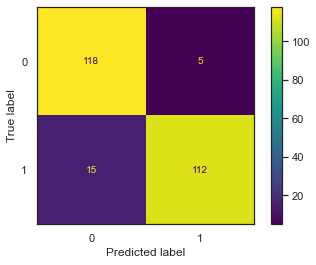

In [22]:
sns.set_theme(style="white")
print(rf_metrics.confusion_matrix)
rf_metrics.plot_confusion_matrix()
sns.set_theme(style="whitegrid")

### Compare Metrics from multiple different Models

In [23]:
metrics_comparison = MetricsComparison(
    metrics=[rf_metrics, gb_metrics, xgb_metrics, lgbm_metrics],
    model_names=["Random Forest", "HistGradientBoosting", "XGBoost", "LightGBM"],
)
metrics_comparison.to_df()

,Random Forest,HistGradientBoosting,XGBoost,LightGBM
Accuracy,0.920000,0.960000,0.956000,0.956000
Precision,0.957265,0.968000,0.967742,0.967742
Recall,0.881890,0.952756,0.944882,0.944882
F1 Score,0.918033,0.960317,0.956175,0.956175
AUC,0.920620,0.960118,0.956181,0.956181


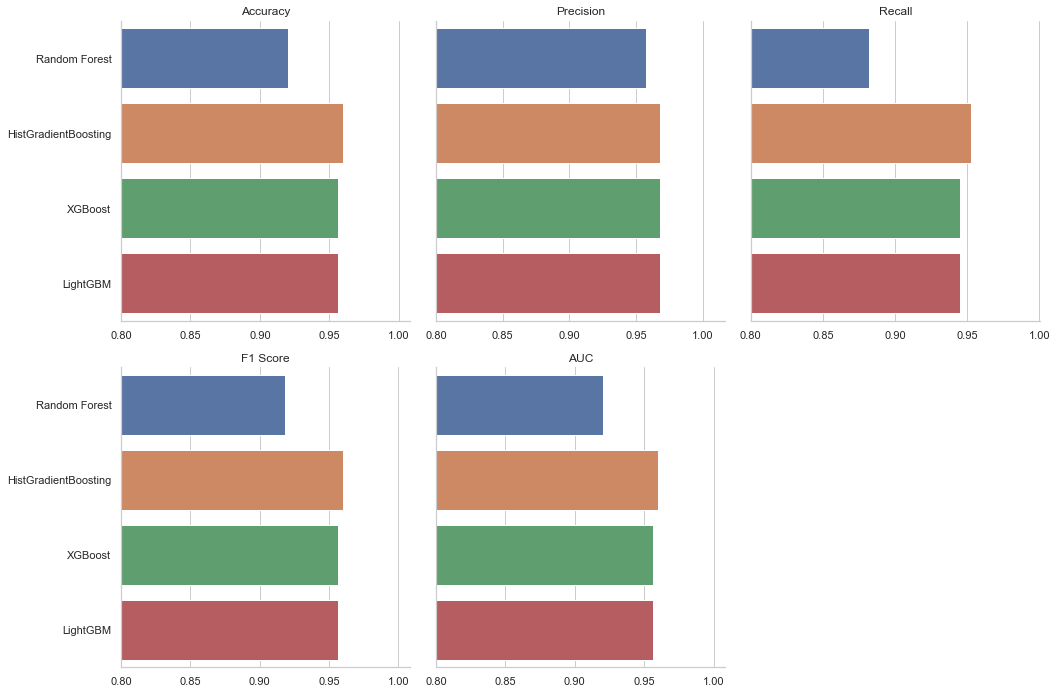

In [24]:
metrics_comparison.barplot(lower_bound=0.8)

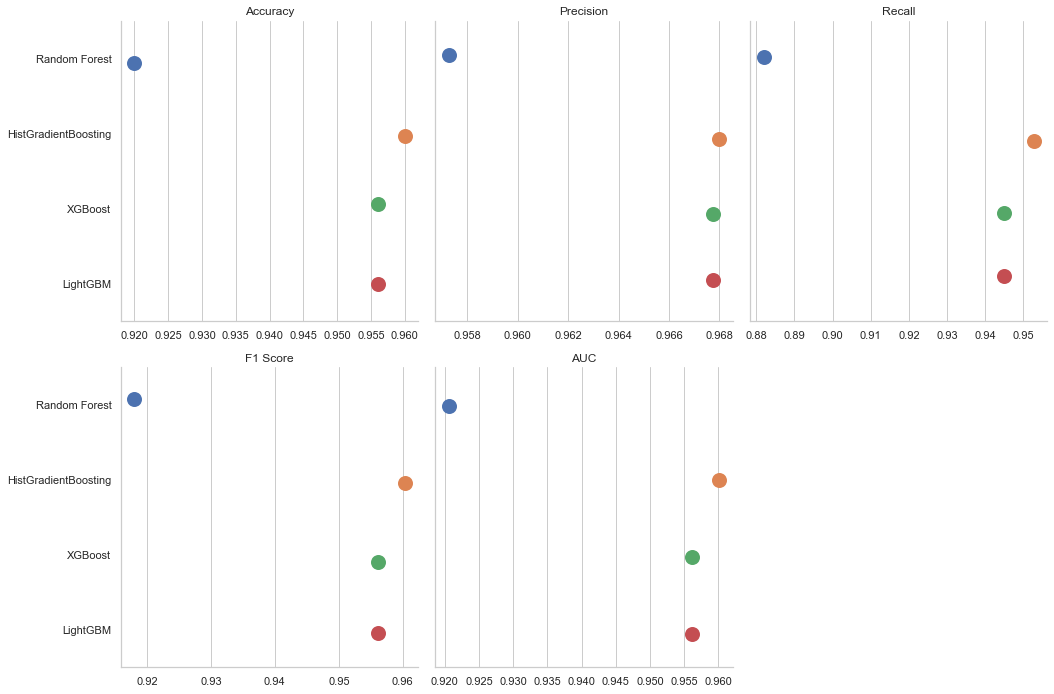

In [25]:
metrics_comparison.stripplot(marker_size=15)